This notebook aims to experiment the Gaussian process machine learning approach to price European Options

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt


from sklearn import gaussian_process

from sklearn.gaussian_process.kernels import RBF

# Import libraries for from local scripts
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import data_processing as dp
from pprint import pprint

In [2]:
df_options = pd.read_csv('../../data/options/options_processed.csv')


In [3]:
df_options_c = df_options.loc[df_options['call_put'] == 'Call']
df_options_c.head()


,date,act_symbol,expiration,strike,call_put,vol,delta,gamma,theta,vega,rho,price,stock_price,time_to_maturity,interest_rate
0,2019-05-10,A,2019-05-17,65.0,Call,0.5636,0.9873,0.0055,-0.0185,0.0035,0.0122,11.725,76.64,0.019178,0.0242
2,2019-05-10,A,2019-05-17,70.0,Call,0.3212,0.9863,0.0102,-0.0133,0.0037,0.0132,7.150,76.64,0.019178,0.0242
4,2019-05-10,A,2019-05-17,72.5,Call,0.4973,0.8252,0.0486,-0.1018,0.0275,0.0112,5.150,76.64,0.019178,0.0242
6,2019-05-10,A,2019-05-17,75.0,Call,0.4644,0.6806,0.0721,-0.1300,0.0381,0.0094,3.200,76.64,0.019178,0.0242
8,2019-05-10,A,2019-05-17,77.5,Call,0.4410,0.4815,0.0847,-0.1365,0.0425,0.0068,1.705,76.64,0.019178,0.0242


In [4]:
params = {
    'name_run': 'gaussian_process_act_test',
    'type_batch': 'create_train_test_set_by_act_symbol', # name of the function to create the batch of data
    'test_size' : 0.2, # proportion of test set
    'test_value' : 200, # if we choose no to train_test_split
    'standardize': True, # standardization of the data
    'number_time_repeat' : 1,
    'pca': False, # PCA on the data
    'n_pc': 10, # number of principal components to keep if PCA is True
    'bs_eval': True, # Black-Scholes evaluation
    'n_rows' : [100, 200, 500, 1000, 2000, 3000, 4000], # number of rows to keep in the dataset
    'features': ['strike', 'stock_price', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'time_to_maturity', 'interest_rate'], # features for the model  
    'gaussian_process': {
        'GaussianProcessRegressor': {
            'kernel': RBF(length_scale=1),
            'n_restarts_optimizer': 1,
            'alpha': 0.01,
            'random_state': 42, 
        }
    }
}

In [5]:
def train_test_model(params):
    dicts_save = {}

    # We instanciate the GaussianProcessRegressor model with the parameters specified in the params dictionary
    gp =[getattr(gaussian_process, type_pro)(**params)for type_pro, params in params['gaussian_process'].items()][0]
    for test_value in params['n_rows']:
        dict_save = {}
        tab_metrics = np.zeros((params['number_time_repeat'], 4))
        tab_metrics_bs = np.zeros((params['number_time_repeat'], 4))
        for i in range(params['number_time_repeat']):
            get_batch_data = getattr(dp, params['type_batch']) 
            X_train, X_test, y_train, y_test, scaler, pca = get_batch_data(df_options_c, 
                                                                                                   params['test_size'], 
                                                                                                   test_value, 
                                                                                                   params['features'], 
                                                                                                   params['standardize'],
                                                                                                    params['pca'],
                                                                                                    params['n_pc']
                                                                                                   )
            if params['pca']: 
                X_test_unpca = pca.inverse_transform(X_test) # for bs model
            else:
                X_test_unpca = X_test
            X_test_unscal = scaler.inverse_transform(X_test_unpca) # for bs model
            gp.fit(X_train, y_train)
            y_pred = gp.predict(X_test)
            mape, mae, mse, r2 = bs.compute_metrics(y_test, y_pred, params, test_value)
            tab_metrics[i] = [mape, mae, mse, r2]

            # for bs evaluation 
            if params['bs_eval']:
                X_test_df, y_test_df = dp.from_np_to_df(X_test_unscal, y_test, params['features'])
                df_price_bs, mape_bs, mae_bs, mse_bs, r2_bs = bs.evaluate_bs_options_pricing(y_test_df, X_test_df)
                tab_metrics_bs[i] = [mape_bs, mae_bs, mse_bs, r2_bs]
                mean_metrics_bs = np.mean(tab_metrics_bs, axis=0)
                std_metrics_bs = np.std(tab_metrics_bs, axis=0)
            else: 
                mean_metrics_bs = -1
                std_metrics_bs = -1

        mean_metrics = np.mean(tab_metrics, axis=0)
        std_metrics = np.std(tab_metrics, axis=0)

        dict_save[params['name_run']] = {
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics,
            'metrics': tab_metrics,
            'mean_metrics_bs': mean_metrics_bs,
            'std_metrics_bs': std_metrics_bs,
            'metrics_bs': tab_metrics_bs,
            'params': params
            }
        dicts_save[test_value] = dict_save
    return dicts_save

In [6]:
dicts_test = train_test_model(params)

Test value 100
name_run :  gaussian_process_act_test
type_batch :  create_train_test_set_by_act_symbol
test_size :  0.2
test_value :  200
standardize :  True
number_time_repeat :  1
pca :  False
n_pc :  10
bs_eval :  True
n_rows :  [100, 200, 500, 1000, 2000, 3000, 4000]
features :  ['strike', 'stock_price', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'time_to_maturity', 'interest_rate']
gaussian_process :  {'GaussianProcessRegressor': {'kernel': RBF(length_scale=1), 'n_restarts_optimizer': 1, 'alpha': 0.01, 'random_state': 42}}
MAPE:  0.1246424476724563
MAE:  0.2453388329860081
MSE:  0.17903050726393288
R2:  0.9992221543881827
-----------------------------------


Black-Scholes Options Pricing Model
MAPE:  0.19321972672942536
MAE:  1.9478332573678196
MSE:  8.304948542587017
R2:  0.9639169442183596
-----------------------------------


Test value 200
name_run :  gaussian_process_act_test
type_batch :  create_train_test_set_by_act_symbol
test_size :  0.2
test_value :  200
standardi

/Users/ambroisethibault/Documents/Cours/TX/survey-ml-finance/venv_tx/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Test value 4000
name_run :  gaussian_process_act_test
type_batch :  create_train_test_set_by_act_symbol
test_size :  0.2
test_value :  200
standardize :  True
number_time_repeat :  1
pca :  False
n_pc :  10
bs_eval :  True
n_rows :  [100, 200, 500, 1000, 2000, 3000, 4000]
features :  ['strike', 'stock_price', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'time_to_maturity', 'interest_rate']
gaussian_process :  {'GaussianProcessRegressor': {'kernel': RBF(length_scale=1), 'n_restarts_optimizer': 1, 'alpha': 0.01, 'random_state': 42}}
MAPE:  0.14240082380022043
MAE:  0.9280138368093188
MSE:  28.307888544645277
R2:  0.9935316708609253
-----------------------------------


Black-Scholes Options Pricing Model
MAPE:  0.3145884547014861
MAE:  4.33058372584576
MSE:  79.80579901553243
R2:  0.9817644408757237
-----------------------------------




In [8]:
for key, value in dicts_test.items():
    print(f"Test value: {key}")
    print('res for gp: ', value[params['name_run']]['mean_metrics'])
    print('res for bs: ', value[params['name_run']]['mean_metrics_bs'])

Test value: 100
res for gp:  [0.12464245 0.24533883 0.17903051 0.99922215]
res for bs:  [0.19321973 1.94783326 8.30494854 0.96391694]
Test value: 200
res for gp:  [0.12464245 0.24533883 0.17903051 0.99922215]
res for bs:  [0.19321973 1.94783326 8.30494854 0.96391694]
Test value: 500
res for gp:  [0.12464245 0.24533883 0.17903051 0.99922215]
res for bs:  [0.19321973 1.94783326 8.30494854 0.96391694]
Test value: 1000
res for gp:  [ 0.05184194  1.3294025  33.05479129  0.99496673]
res for bs:  [  0.21667248   6.81328335 151.31355625   0.9769594 ]
Test value: 2000
res for gp:  [0.18327113 0.84147034 9.66666754 0.99717341]
res for bs:  [ 0.33958523  4.73113617 90.64206005  0.97349573]
Test value: 3000
res for gp:  [0.12182156 0.82476811 8.9465726  0.99819726]
res for bs:  [ 0.33968257  5.25844555 89.20558837  0.982025  ]
Test value: 4000
res for gp:  [ 0.14240082  0.92801384 28.30788854  0.99353167]
res for bs:  [ 0.31458845  4.33058373 79.80579902  0.98176444]


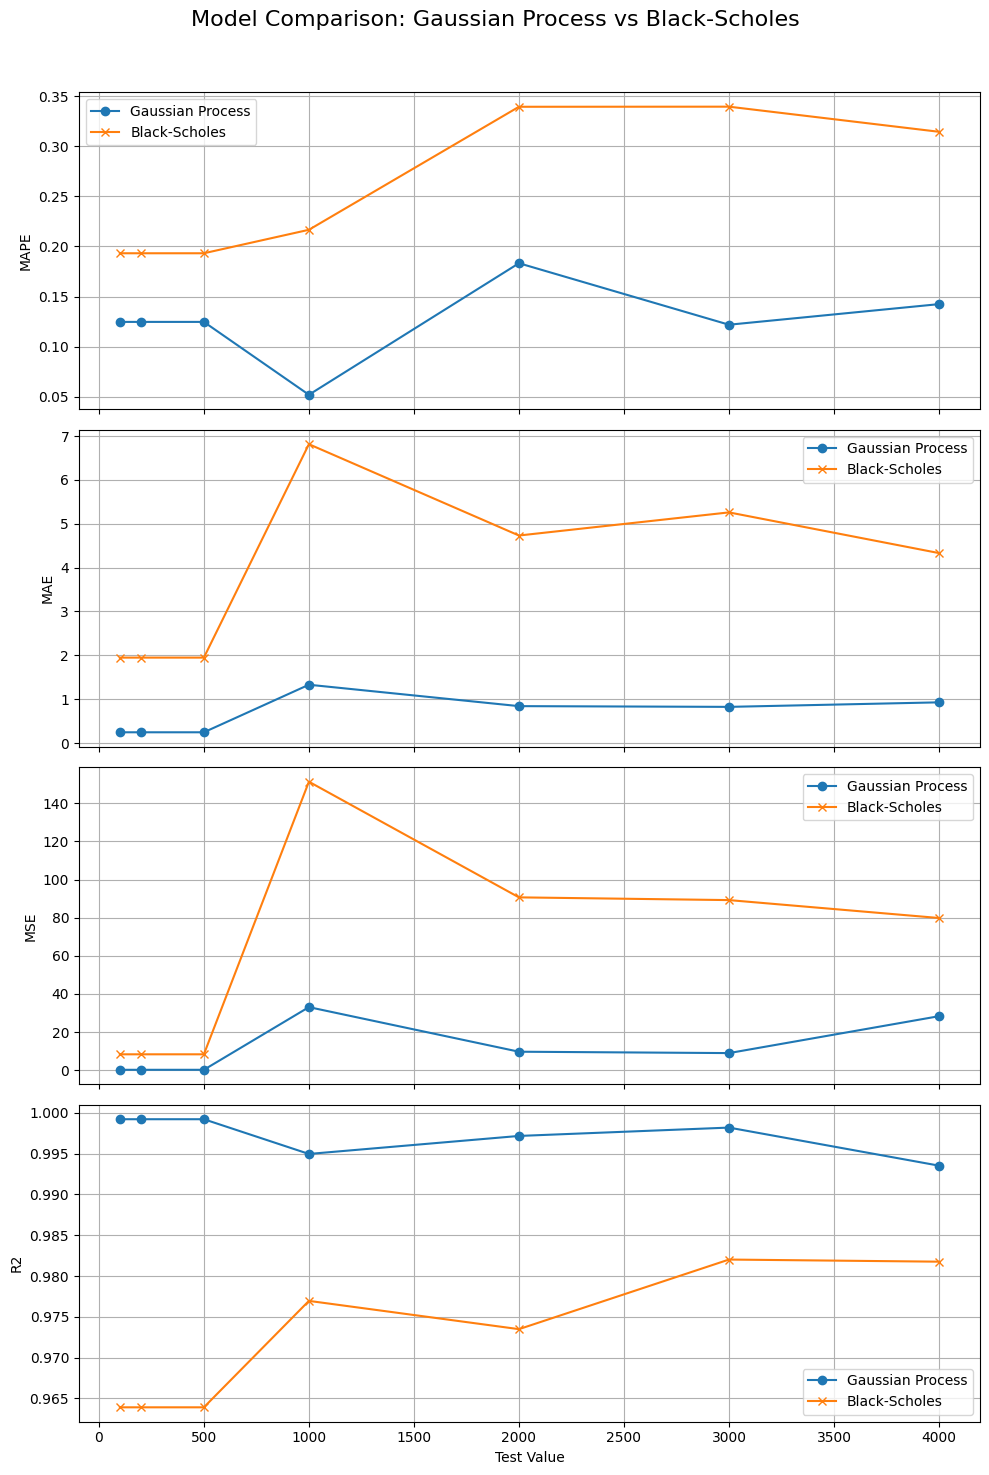

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison_from_dict(dicts_test, params):
    # Define the metric names
    metrics = ['MAPE', 'MAE', 'MSE', 'R2']
    
    # Extract test values and corresponding results
    test_values = list(dicts_test.keys())
    gp_results = [dicts_test[key][params['name_run']]['mean_metrics'] for key in test_values]
    bs_results = [dicts_test[key][params['name_run']]['mean_metrics_bs'] for key in test_values]
    
    # Number of metrics
    num_metrics = len(metrics)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(num_metrics, 1, figsize=(10, 15), sharex=True)
    
    for i in range(num_metrics):
        gp_metric_values = [res[i] for res in gp_results]
        bs_metric_values = [res[i] for res in bs_results]
        
        axs[i].plot(test_values, gp_metric_values, label='Gaussian Process', marker='o')
        axs[i].plot(test_values, bs_metric_values, label='Black-Scholes', marker='x')
        axs[i].set_ylabel(metrics[i])
        axs[i].legend()
        axs[i].grid(True)
    
    axs[-1].set_xlabel('Test Value')
    plt.suptitle('Model Comparison: Gaussian Process vs Black-Scholes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
plot_model_comparison_from_dict(dicts_test, params)

## Données générées par BS

In [1]:
r = 0.0002  
S= 100
K = 130
sigma = 0.4 
T = 2.0     

In [54]:
# Lower bound and upper bound for the stock price generation
lb = 0.001           
ub = 300             

training_number = 10 
testing_number = 100 


# Generate the training and testing data 
train_x_1 = np.linspace(0, 1, training_number).astype('float32').reshape(training_number, 1)
train_y_1 = [bs.bs_options_pricing(lb + (ub - lb) * S, K, r, T, sigma)[0] for S in train_x_1]

test_x_1 = np.linspace(0, 1, testing_number).astype('float32').reshape(testing_number, 1)
test_y_1 = [bs.bs_options_pricing(lb + (ub - lb) * S, K, r, T, sigma)[0] for S in test_x_1]


In [55]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1, train_y_1) # We train the model 

/Users/ambroisethibault/Documents/Cours/TX/dev/venv_tx/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [56]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)
mape, mae, mse, r2 = bs.compute_metrics(test_y_1, y_pred_1)

MAPE:  38275986.86015128
MAE:  0.43795866673259437
MSE:  0.6488689698568444
R2:  0.9997890058329256
-----------------------------------




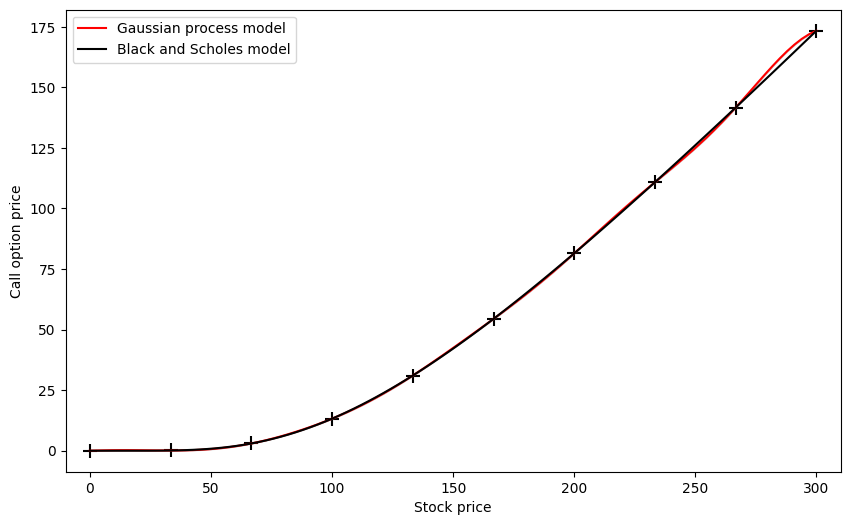

In [57]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'Gaussian process model')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Black and Scholes model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('Stock price')
plt.ylabel('Call option price')